In [1]:
import itertools, copy
import json
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('../peptidome.mplstyle')

import evcouplings.align, evcouplings.couplings

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [29]:
h = pd.read_csv('data/Human_N9_h.csv', index_col=0)
Jks = pd.read_csv('data/Human_N9_Jk.csv', index_col=0)
Jks

,J0,J1,J2,J3,J4,J5,J6,J7,J8,J9,J10,J11,J12,J13,J14,J15,J16,J17,J18
AA,0.228560,0.173397,0.141823,0.184784,0.113928,0.117920,0.125722,0.104917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC,-0.065616,-0.032995,-0.068414,-0.039321,-0.067687,-0.047460,-0.065956,-0.034189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AD,-0.094089,-0.042232,-0.066877,-0.055209,-0.044286,-0.049554,-0.045455,-0.027282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AE,-0.024541,-0.036119,-0.023266,-0.046423,-0.041028,-0.020982,-0.037217,-0.018332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AF,0.082255,-0.056366,-0.035546,-0.024241,-0.030724,-0.020651,-0.038478,-0.045192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YS,0.013079,-0.058190,-0.013459,-0.063121,-0.039503,-0.065003,-0.057829,-0.042648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YT,0.007375,-0.032029,0.002465,-0.021070,-0.012864,-0.032489,-0.017652,-0.016113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YV,-0.011060,0.006707,0.013074,0.086652,-0.049466,-0.035324,0.018123,-0.020152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
YW,0.083965,0.025509,0.032637,0.046922,-0.002685,0.056054,0.141184,0.071533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
params = np.load('data/Human_N9.npz')
h = params['h']
Jk = params['Jk']

In [40]:
N = 9
q = naminoacids
prng = np.random
nmcmc = 1e6
aas_arr = np.array(list(aminoacids))

In [41]:
def energy(x):
    return clib.energy(x, h, Jk)
x0 = prng.randint(q, size=N)
def jump(x):
    return local_jump(x, q)
samples = mcmcsampler(x0, energy, jump, nmcmc*10, nsample=10)
samples = [''.join(aas_arr[s]) for s in samples]

In [6]:
seed = 1234
prng = np.random.RandomState(seed)
proteome = proteome_path('Human')
seqs = [s for s in fasta_iter(proteome, returnheader=False)]
train, test = train_test_split(seqs, test_size=0.5, random_state=prng)

In [42]:
df1s = []
df2s = []
for i, seqs in enumerate([train, test, samples]):
    df1 = pseudocount_f1(seqs)
    df1s.append(df1)
    df2s.append([list(pseudocount_f2(seqs, 2, gap, df1)['freq'])  for gap in range(0, N-1)])

In [8]:
train_kmers = list(to_kmers(train, k=N))
test_kmers = list(to_kmers(test, k=N))

In [46]:
mapped_seqs

array([[10, 10,  9, ...,  5, 15,  6],
       [17,  0,  9, ...,  5, 15,  6],
       [ 0, 17, 14, ...,  5, 15,  6],
       ...,
       [ 0,  0, 13, ...,  1, 11, 15],
       [ 0,  9, 13, ...,  1,  0,  3],
       [ 0,  8, 10, ..., 18,  0, 13]])

In [43]:
fis = []
cijs = []
for i, seqs in enumerate([train_kmers, test_kmers, samples]):
    seqs_arr = np.array([list(sample) for sample in seqs])
    map_ = map_ = {c: i for i, c in enumerate(aminoacids)}
    mapped_seqs = evcouplings.align.map_matrix(seqs_arr, map_)
    fi = evcouplings.align.frequencies(mapped_seqs, np.ones(len(seqs)), num_symbols=q)
    fij = evcouplings.align.pair_frequencies(mapped_seqs, np.ones(len(seqs)), num_symbols=q, fi=fi)
    cij = evcouplings.couplings.compute_covariance_matrix(fi, fij).flatten()
    fis.append(fi.copy())
    cijs.append(cij.copy())

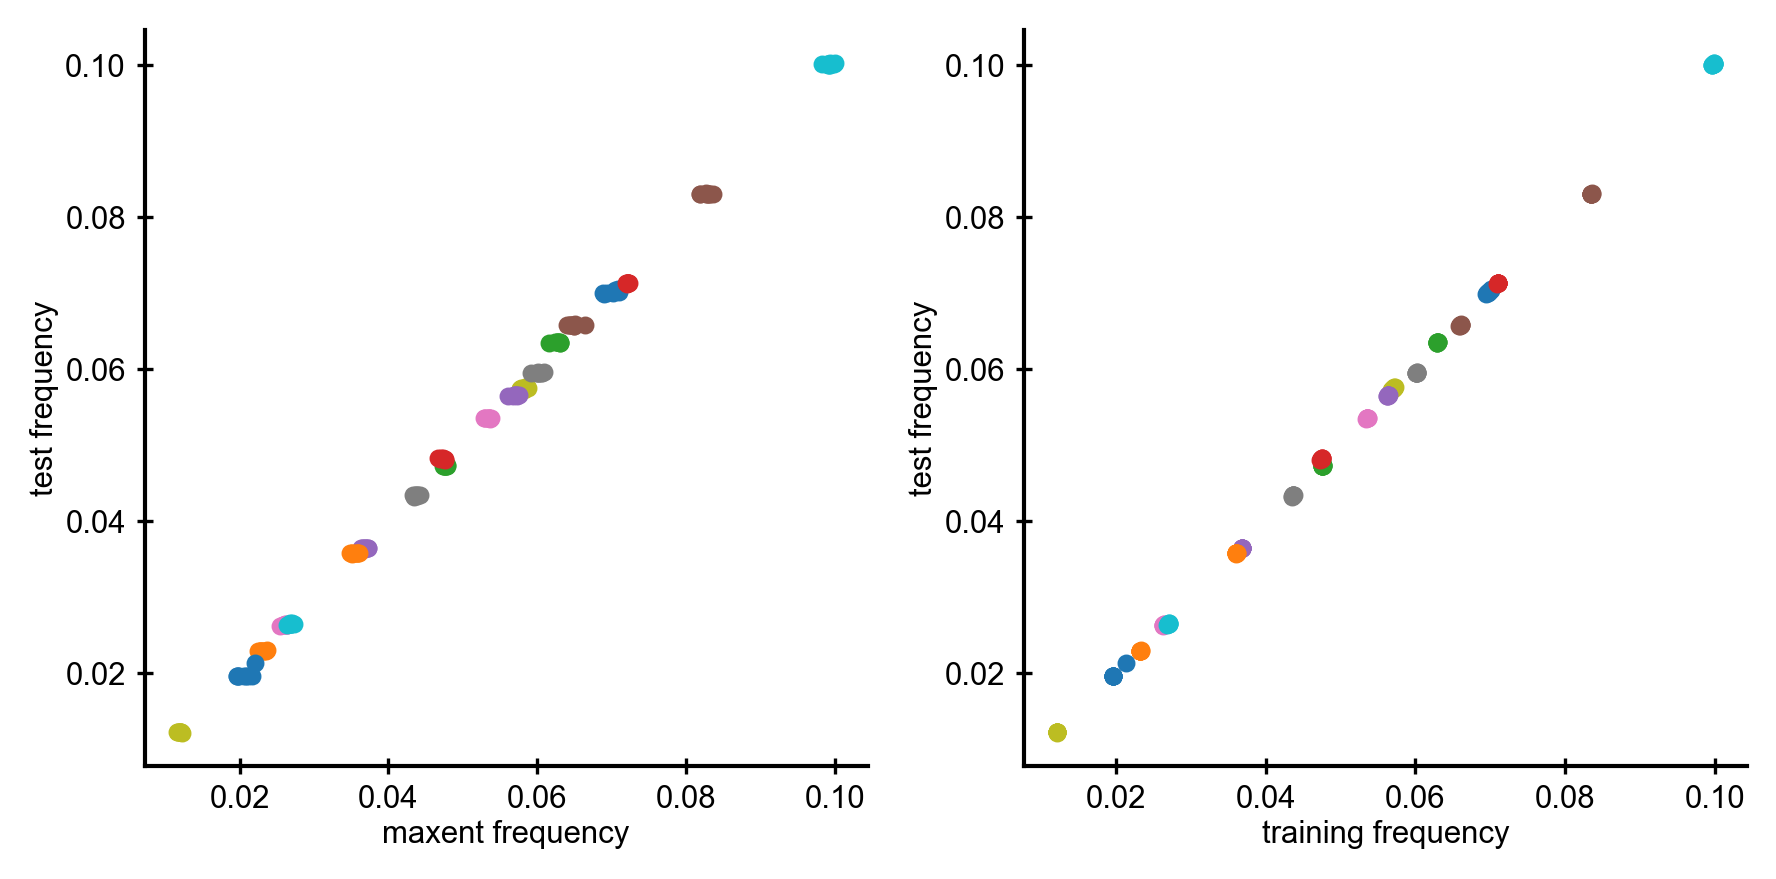

In [44]:
fig, axes = plt.subplots(figsize=(6, 3), ncols=2)
axes[0].plot(fis[2], fis[1], 'o')
axes[0].set_xlabel('maxent frequency')
axes[1].plot(fis[0], fis[1], 'o')
axes[1].set_xlabel('training frequency')
for ax in axes:
    ax.set_ylabel('test frequency')
fig.tight_layout()

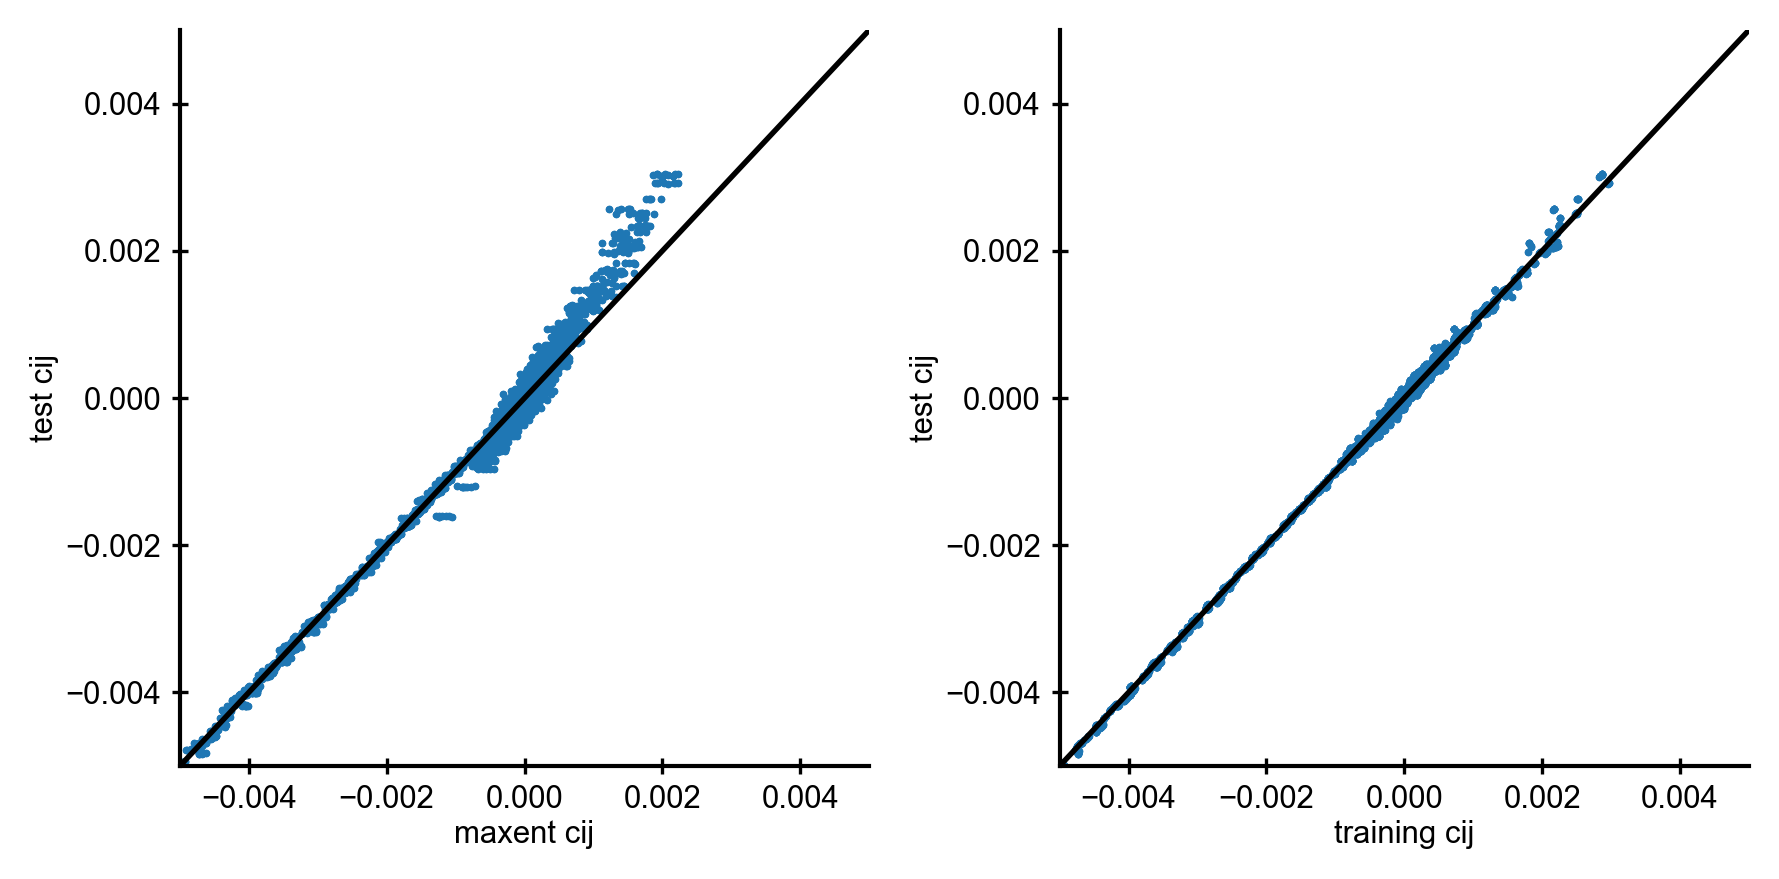

In [45]:
lim = 0.005
fig, axes = plt.subplots(figsize=(6, 3), ncols=2)
axes[0].plot(cijs[2].flatten(), cijs[1].flatten(), 'o', ms=1)
axes[0].set_xlabel('maxent cij')
axes[1].plot(cijs[0].flatten(), cijs[1].flatten(), 'o', ms=1)
axes[1].set_xlabel('training cij')
for ax in axes:
    ax.set_ylabel('test cij')
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.plot([-lim, lim], [-lim, lim], 'k')
fig.tight_layout()